# NB-AK5: Changes in monthly seasonality in total fluxes and states per basin

## module loading...

In [1]:
%matplotlib inline  
import os
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)

mpl.rcParams['xtick.labelsize']='small'
mpl.rcParams['ytick.labelsize']='small'


The Python version: 3.7.0
xarray 0.16.2


In [2]:
from cmip5_oconus import print_date
print_date()

from cmip5_oconus.data_catalog import load_monthly_historical_hydro_datasets, resample_data
from cmip5_oconus.data_catalog import load_monthly_cmip5_hydro_datasets
from cmip5_oconus.plot import custom_div_cmap, MidpointNormalize, add_ylabel
from cmip5_oconus.utils import calc_change

Last executed: 2021-03-08 20:50:42.075073 by mizukami on casper01


In [3]:
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=9, threads=4, memory="108GB",
#                  walltime='00:40:00')
#cluster.scale(jobs=3)

#from dask_jobqueue import SLURMCluster
#cluster = SLURMCluster()
#cluster.scale(jobs=5)

In [4]:
#from dask.distributed import Client
#client = Client(cluster)

In [5]:
#client

-------------------------
## Setup 

In [3]:
figSave = True

In [4]:
gcms            = ["ACCESS1-3","CanESM2","CCSM4","CSIRO-Mk3-6-0","GFDL-ESM2M","HadGEM2-ES","inmcm4","MIROC5","MPI-ESM-MR","MRI-CGCM3"]
hydro_flux_vars = ['PRCP', 'EVAP', 'total_runoff','GLACIER_MELT','SNOW_MELT','SM1','SM2','SM3','IWE','SWE']
period_hist     = slice('1970-01-01', '1999-12-31')
period_futr     = {'early' : slice('2010-01-01', '2039-12-31'),
                   'middle': slice('2040-01-01', '2069-12-31'),
                   'late'  : slice('2070-01-01', '2099-12-31')}

basin_name = {776:'Copper', 784:'Tanana', 786:'Porcupine',7892:'White', 7897:'Teslin', 798:'Colville'}

## Load the data

In [5]:
xr.set_options(file_cache_maxsize=12000)
histo_data = load_monthly_historical_hydro_datasets(models=gcms, variables=hydro_flux_vars, region='AK', dataType='hrus', parallel=False)
rcp45_data = load_monthly_cmip5_hydro_datasets(scen='rcp45', models=gcms, variables=hydro_flux_vars, region='AK', dataType='hrus', parallel=False)
rcp85_data = load_monthly_cmip5_hydro_datasets(scen='rcp85', models=gcms, variables=hydro_flux_vars, region='AK',dataType='hrus',  parallel=False)

load_monthly_historical_hydro_datasets
load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [00:20<00:00,  2.02s/it]

load_obs_dataset


load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]

load_monthly_cmip5_hydro_datasets
load_cmip5_dataset



100%|██████████| 10/10 [00:38<00:00,  3.86s/it]


## Compute monthly climatology during 30 year period - historical, early, mid and late

In [6]:
histo_data['gcm']['SM'] = histo_data['gcm']['SM1'] + histo_data['gcm']['SM2'] + histo_data['gcm']['SM2']
histo_data['gcm']['dSM'] = histo_data['gcm']['SM'].diff(dim='time')
histo_data['gcm']['dSWE'] = histo_data['gcm']['SWE'].diff(dim='time')
histo_data['gcm']['dIWE'] = histo_data['gcm']['IWE'].diff(dim='time')
histo_data['gcm'] = histo_data['gcm'].drop(['SM1','SM2','SM3'])

rcp45_data['SM']  = rcp45_data['SM1'] + rcp45_data['SM2'] + rcp45_data['SM3']
rcp45_data['dSM'] = rcp45_data['SM'].diff(dim='time')
rcp45_data['dSWE'] = rcp45_data['SWE'].diff(dim='time')
rcp45_data['dIWE'] = rcp45_data['IWE'].diff(dim='time')
rcp45_data = rcp45_data.drop(['SM1','SM2','SM3'])

rcp85_data['SM']  = rcp85_data['SM1'] + rcp85_data['SM2'] + rcp85_data['SM3']
rcp85_data['dSM'] = rcp85_data['SM'].diff(dim='time')
rcp85_data['dSWE'] = rcp85_data['SWE'].diff(dim='time')
rcp85_data['dIWE'] = rcp85_data['IWE'].diff(dim='time')
rcp85_data = rcp85_data.drop(['SM1','SM2','SM3'])

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/core.py:3929: PerformanceWarning: Increasing number of chunks by factor of 10
  **blockwise_kwargs,
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/core.py:3929: PerformanceWarning: Increasing number of chunks by factor of 10
  **blockwise_kwargs,
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/core.py:3929: PerformanceWarning: Increasing number of chunks by factor of 10
  **blockwise_kwargs,
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/core.py:3929: PerformanceWarning: Increasing number of chunks by factor of 10
  **blockwise_kwargs,
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/core.py:3929: PerformanceWarning: Increasing number of chunks by factor of 10
  **blockwise_kwargs,
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus

In [7]:
histo_hydro_season = histo_data['gcm'].sel(time=period_hist).groupby('time.month').mean(dim="time").persist()

rcp45_hydro_season = {}
rcp85_hydro_season = {}
for key, futr_period in period_futr.items():
    rcp45_hydro_season[key] = rcp45_data.sel(time=futr_period).groupby('time.month').mean('time').persist()
    rcp85_hydro_season[key] = rcp85_data.sel(time=futr_period).groupby('time.month').mean('time').persist()

In [8]:
rcp45_hydro_season

{'early': <xarray.Dataset>
 Dimensions:       (basinID: 28, gcm: 10, month: 12)
 Coordinates:
   * basinID       (basinID) int32 775 776 777 778 779 ... 7892 7894 7896 7897
   * gcm           (gcm) <U13 'ACCESS1-3' 'CanESM2' ... 'MPI-ESM-MR' 'MRI-CGCM3'
   * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
 Data variables:
     PRCP          (month, gcm, basinID) float32 dask.array<chunksize=(1, 1, 28), meta=np.ndarray>
     EVAP          (month, gcm, basinID) float32 dask.array<chunksize=(1, 1, 28), meta=np.ndarray>
     total_runoff  (month, gcm, basinID) float32 dask.array<chunksize=(1, 1, 28), meta=np.ndarray>
     GLACIER_MELT  (month, gcm, basinID) float32 dask.array<chunksize=(1, 1, 28), meta=np.ndarray>
     SNOW_MELT     (month, gcm, basinID) float32 dask.array<chunksize=(1, 1, 28), meta=np.ndarray>
     IWE           (month, gcm, basinID) float32 dask.array<chunksize=(1, 1, 28), meta=np.ndarray>
     SWE           (month, gcm, basinID) float32 dask.array<chunksize=(1, 1

## Plotting

------------
 Long-term mean of annual flux annual cycles for historical vs futures
 
 PRCP, EVAP and RUNOFF

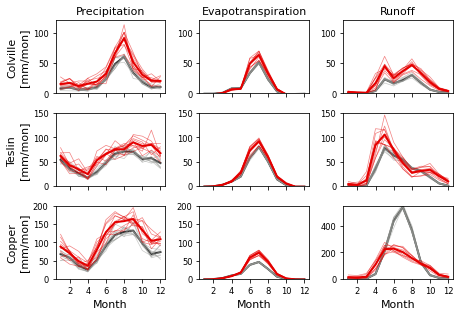

In [10]:
style_kwargs = {'ls': '-'}
kwargs       = {'hist': {'mean':{'lw':2.0, 'color':'xkcd:dark grey', **style_kwargs}, 'ens':{'lw':0.7, 'color':'xkcd:grey', 'alpha':0.5, **style_kwargs}},
                'rcp':  {'mean':{'lw':2.0, 'color':'xkcd:red', **style_kwargs}, 'ens':{'lw':0.7, 'color':'xkcd:red', 'alpha':0.5, **style_kwargs}}
               }
xlabel = []
var_title = {'PRCP':'Precipitation', 'EVAP':'Evapotranspiration', 'total_runoff':'Runoff'}

fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=(6.5,4.5))
for row, basin in enumerate([798,7897,776]):
    for col, var in enumerate(['PRCP','EVAP','total_runoff']):
        
        ax=axes[row, col]
        histo_hydro_season.mean(dim='gcm')[var].sel(basinID=basin).plot.line(ax=ax, x='month', **kwargs['hist']['mean'])
        histo_hydro_season[var].sel(basinID=basin).plot.line(ax=ax, x='month', **kwargs['hist']['ens'])

        rcp85_hydro_season['late'].mean(dim='gcm')[var].sel(basinID=basin).plot.line(ax=ax, x='month', **kwargs['rcp']['mean'])
        rcp85_hydro_season['late'][var].sel(basinID=basin).plot.line(ax=ax, x='month', **kwargs['rcp']['ens'])
    
        ax.set_xticks(np.arange(2, 13, step=2))
        
        if col==0:
            ax.set_ylabel(f'{basin_name[basin]}\n[mm/mon]', fontsize=11)
        else:
            ax.set_ylabel('')

        if row==0:
            ax.set_ylim([0, 120])
            ax.set_xlabel('')
            ax.set_title(var_title[var], fontsize=11)
        elif row==1:
            ax.set_ylim([0, 150])
            ax.set_xlabel('')
            ax.set_title('')           
        elif row==2 and col!=2:
            ax.set_ylim([0, 200])
            ax.set_xlabel('Month',fontsize=11)
            ax.set_title('')
        elif row==2 and col==2:
            ax.set_ylim([0, 550]) 
            ax.set_xlabel('Month',fontsize=11)
            ax.set_title('')
            
        ax.get_legend().remove()
    
plt.tight_layout()
plt.savefig(f'NB-AK5_Fig1_annual_cycle_three_basins.png', dpi=300)

------------
 The same as above except for PRCP, EVAP, RUNOFF, ice+snow melt

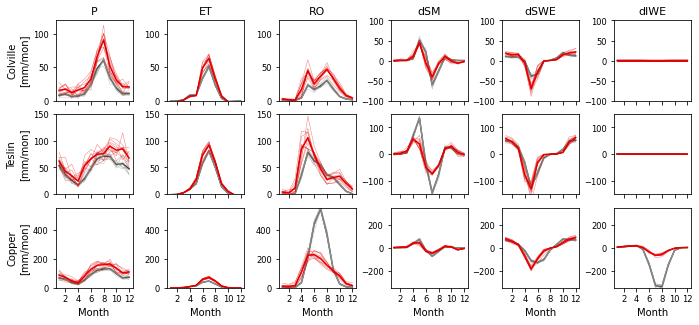

In [12]:
style_kwargs = {'ls': '-'}
kwargs       = {'hist': {'mean':{'lw':1.5, 'color':'xkcd:dark grey', **style_kwargs}, 'ens':{'lw':0.5, 'color':'xkcd:grey', 'alpha':0.5, **style_kwargs}},
                'rcp':  {'mean':{'lw':1.5, 'color':'xkcd:red', **style_kwargs}, 'ens':{'lw':0.5, 'color':'xkcd:red', 'alpha':0.5, **style_kwargs}}
               }
xlabel = []
var_title = {'PRCP':'P', 'EVAP':'ET', 'total_runoff':'RO','dSM':'dSM','dSWE':'dSWE', 'dIWE':'dIWE'}

fig, axes = plt.subplots(nrows=3, ncols=6, sharex=True, sharey=False, figsize=(9.75, 4.5)) # used to be 6.5, 4.5
plt.subplots_adjust(left=0.080, bottom=0.100, right=0.985, top=0.925, hspace=0.170, wspace=0.45)

for row, basin in enumerate([798,7897,776]):
    for col, var in enumerate(['PRCP','EVAP','total_runoff','dSM','dSWE','dIWE']):
        
        ax=axes[row, col]
        histo_hydro_season.mean(dim='gcm')[var].sel(basinID=basin).plot.line(ax=ax, x='month', **kwargs['hist']['mean'])
        histo_hydro_season[var].sel(basinID=basin).plot.line(ax=ax, x='month', **kwargs['hist']['ens'])

        rcp85_hydro_season['late'].mean(dim='gcm')[var].sel(basinID=basin).plot.line(ax=ax, x='month', **kwargs['rcp']['mean'])
        rcp85_hydro_season['late'][var].sel(basinID=basin).plot.line(ax=ax, x='month', **kwargs['rcp']['ens'])
    
        ax.set_xticks(np.arange(2, 13, step=2))
        
        if row==0:
            ax.set_xlabel('')
            ax.set_title(var_title[var], fontsize=11)
            if col==0:
                ax.set_ylim([0, 120])
                ax.set_ylabel(f'{basin_name[basin]}\n[mm/mon]', fontsize=10)
            elif col==1 or col==2:
                ax.set_ylabel('')
                ax.set_ylim([0, 120])
            elif col==3 or col==4 or col==5:
                ax.set_ylabel('')
                ax.set_ylim([-100, 100])
                
        elif row==1:
            ax.set_title('')
            ax.set_xlabel('')
            if col==0:
                ax.set_ylim([0, 150])
                ax.set_ylabel(f'{basin_name[basin]}\n[mm/mon]', fontsize=10)
            elif col==1 or col==2:
                ax.set_ylabel('')
                ax.set_ylim([0, 150])
            elif col==3 or col==4 or col==5:
                ax.set_ylabel('')
                ax.set_ylim([-150, 150])
                
        elif row==2:
            ax.set_xlabel('Month',fontsize=10)
            ax.set_title('')  
            if col==0:
                ax.set_ylim([0, 550])
                ax.set_ylabel(f'{basin_name[basin]}\n[mm/mon]', fontsize=10)
            if col==1 or col==2:
                ax.set_ylabel('')
                ax.set_ylim([0, 550])
            elif col==3 or col==4 or col==5:
                ax.set_ylabel('')
                ax.set_ylim([-350, 350])
                      
        ax.get_legend().remove()
    
#plt.tight_layout()
plt.savefig(f'NB-AK5_Fig2_annual_cycle_flux_state_three_basins.png', dpi=300)

------------
 - North Slope

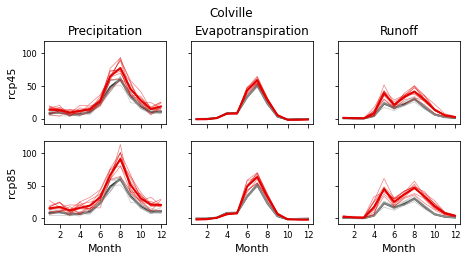

In [20]:
basinID=798

style_kwargs = {'ls': '-'}
kwargs       = {'hist': {'mean':{'lw':2.0, 'color':'xkcd:dark grey', **style_kwargs}, 'ens':{'lw':0.7, 'color':'xkcd:grey', 'alpha':0.5, **style_kwargs}},
                'rcp':  {'mean':{'lw':2.0, 'color':'xkcd:red', **style_kwargs}, 'ens':{'lw':0.7, 'color':'xkcd:red', 'alpha':0.5, **style_kwargs}}
               }
xlabel = []
var_title = {'PRCP':'Precipitation', 'EVAP':'Evapotranspiration', 'total_runoff':'Runoff'}

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(6.5,3.5))
plt.subplots_adjust(left=0.1, bottom=0.125, right=0.99, top=0.85)

for row, rcp in enumerate(['rcp45','rcp85']):
    for col, var in enumerate(['PRCP','EVAP','total_runoff']):
        
        ax=axes[row, col]
        histo_hydro_season.mean(dim='gcm')[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['hist']['mean'])
        histo_hydro_season[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['hist']['ens'])
        if rcp == 'rcp45':
            rcp45_hydro_season['late'].mean(dim='gcm')[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['mean'])
            rcp45_hydro_season['late'][var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['ens'])
        elif rcp=='rcp85':
            rcp85_hydro_season['late'].mean(dim='gcm')[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['mean'])
            rcp85_hydro_season['late'][var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['ens'])
    
        ax.set_xticks(np.arange(2, 13, step=2))
        
        if col==0:
            if row==0:
                ax.set_ylabel(rcp, fontsize=11)
            elif row==1:
                ax.set_ylabel(rcp, fontsize=11)
        else:
            ax.set_ylabel('')
        
        if row==0:        
            ax.set_xlabel('')
            ax.set_title(var_title[var], fontsize=12)
        elif row==1:
            ax.set_xlabel('Month',fontsize=11)
            ax.set_title('')
    
        ax.get_legend().remove()
    
fig.suptitle(basin_name[basinID], fontsize=12, y=0.985)
plt.savefig(f'NB-AK5_Fig3_annual_cycle_{basin_name[basinID]}.png', dpi=300)

------------
 - Yukon River

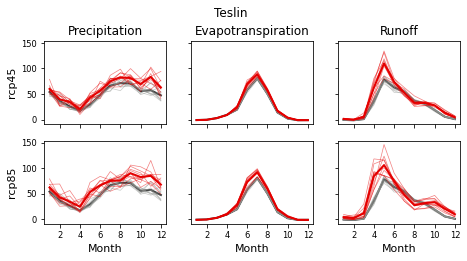

In [21]:
basinID=7897

style_kwargs = {'ls': '-'}
kwargs       = {'hist': {'mean':{'lw':2.0, 'color':'xkcd:dark grey', **style_kwargs}, 'ens':{'lw':0.7, 'color':'xkcd:grey', 'alpha':0.5, **style_kwargs}},
                'rcp':  {'mean':{'lw':2.0, 'color':'xkcd:red', **style_kwargs}, 'ens':{'lw':0.7, 'color':'xkcd:red', 'alpha':0.5, **style_kwargs}}
               }
xlabel = []
var_title = {'PRCP':'Precipitation', 'EVAP':'Evapotranspiration', 'total_runoff':'Runoff'}

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(6.5,3.5))
plt.subplots_adjust(left=0.1, bottom=0.125, right=0.99, top=0.85)

for row, rcp in enumerate(['rcp45','rcp85']):
    for col, var in enumerate(['PRCP','EVAP','total_runoff']):
        
        ax=axes[row, col]
        histo_hydro_season.mean(dim='gcm')[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['hist']['mean'])
        histo_hydro_season[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['hist']['ens'])
        if rcp == 'rcp45':
            rcp45_hydro_season['late'].mean(dim='gcm')[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['mean'])
            rcp45_hydro_season['late'][var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['ens'])
        elif rcp=='rcp85':
            rcp85_hydro_season['late'].mean(dim='gcm')[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['mean'])
            rcp85_hydro_season['late'][var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['ens'])
    
        ax.set_xticks(np.arange(2, 13, step=2))
        
        if col==0:
            if row==0:
                ax.set_ylabel(rcp, fontsize=11)
            elif row==1:
                ax.set_ylabel(rcp, fontsize=11)
        else:
            ax.set_ylabel('')
        
        if row==0:        
            ax.set_xlabel('')
            ax.set_title(var_title[var], fontsize=12)
        elif row==1:
            ax.set_xlabel('Month',fontsize=11)
            ax.set_title('')
    
        ax.get_legend().remove()
    
fig.suptitle(basin_name[basinID], fontsize=12, y=0.985)
plt.savefig(f'NB-AK5_Fig4_annual_cycle_{basin_name[basinID]}.png', dpi=300)

------------
 - Southeast Alaska

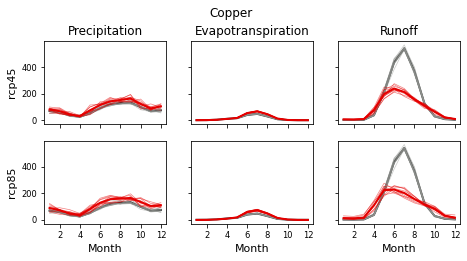

In [23]:
basinID=776 

style_kwargs = {'ls': '-'}
kwargs       = {'hist': {'mean':{'lw':2.0, 'color':'xkcd:dark grey', **style_kwargs}, 'ens':{'lw':0.7, 'color':'xkcd:grey', 'alpha':0.5, **style_kwargs}},
                'rcp':  {'mean':{'lw':2.0, 'color':'xkcd:red', **style_kwargs}, 'ens':{'lw':0.7, 'color':'xkcd:red', 'alpha':0.5, **style_kwargs}}
               }
xlabel = []
var_title = {'PRCP':'Precipitation', 'EVAP':'Evapotranspiration', 'total_runoff':'Runoff'}

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(6.5,3.5))
plt.subplots_adjust(left=0.1, bottom=0.125, right=0.99, top=0.85)

for row, rcp in enumerate(['rcp45','rcp85']):
    for col, var in enumerate(['PRCP','EVAP','total_runoff']):
        
        ax=axes[row, col]
        histo_hydro_season.mean(dim='gcm')[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['hist']['mean'])
        histo_hydro_season[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['hist']['ens'])
        if rcp == 'rcp45':
            rcp45_hydro_season['late'].mean(dim='gcm')[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['mean'])
            rcp45_hydro_season['late'][var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['ens'])
        elif rcp=='rcp85':
            rcp85_hydro_season['late'].mean(dim='gcm')[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['mean'])
            rcp85_hydro_season['late'][var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['ens'])
    
        ax.set_xticks(np.arange(2, 13, step=2))
        
        if col==0:
            if row==0:
                ax.set_ylabel(rcp, fontsize=11)
            elif row==1:
                ax.set_ylabel(rcp, fontsize=11)
        else:
            ax.set_ylabel('')
        
        if row==0:        
            ax.set_xlabel('')
            ax.set_title(var_title[var], fontsize=12)
        elif row==1:
            ax.set_xlabel('Month',fontsize=11)
            ax.set_title('')
    
        ax.get_legend().remove()
    
fig.suptitle(basin_name[basinID], fontsize=12, y=0.985)
plt.savefig(f'NB-AK5_Fig5_annual_cycle_{basin_name[basinID]}.png', dpi=300)

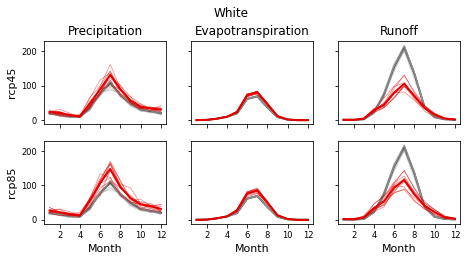

In [24]:
basinID=7892 

style_kwargs = {'ls': '-'}
kwargs       = {'hist': {'mean':{'lw':2.0, 'color':'xkcd:dark grey', **style_kwargs}, 'ens':{'lw':0.7, 'color':'xkcd:grey', 'alpha':0.5, **style_kwargs}},
                'rcp':  {'mean':{'lw':2.0, 'color':'xkcd:red', **style_kwargs}, 'ens':{'lw':0.7, 'color':'xkcd:red', 'alpha':0.5, **style_kwargs}}
               }
xlabel = []
var_title = {'PRCP':'Precipitation', 'EVAP':'Evapotranspiration', 'total_runoff':'Runoff'}

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(6.5,3.5))
plt.subplots_adjust(left=0.1, bottom=0.125, right=0.99, top=0.85)

for row, rcp in enumerate(['rcp45','rcp85']):
    for col, var in enumerate(['PRCP','EVAP','total_runoff']):
        
        ax=axes[row, col]
        histo_hydro_season.mean(dim='gcm')[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['hist']['mean'])
        histo_hydro_season[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['hist']['ens'])
        if rcp == 'rcp45':
            rcp45_hydro_season['late'].mean(dim='gcm')[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['mean'])
            rcp45_hydro_season['late'][var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['ens'])
        elif rcp=='rcp85':
            rcp85_hydro_season['late'].mean(dim='gcm')[var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['mean'])
            rcp85_hydro_season['late'][var].sel(basinID=basinID).plot.line(ax=ax, x='month', **kwargs['rcp']['ens'])
    
        ax.set_xticks(np.arange(2, 13, step=2))
        
        if col==0:
            if row==0:
                ax.set_ylabel(rcp, fontsize=11)
            elif row==1:
                ax.set_ylabel(rcp, fontsize=11)
        else:
            ax.set_ylabel('')
        
        if row==0:        
            ax.set_xlabel('')
            ax.set_title(var_title[var], fontsize=12)
        elif row==1:
            ax.set_xlabel('Month',fontsize=11)
            ax.set_title('')
    
        ax.get_legend().remove()
    
fig.suptitle(basin_name[basinID], fontsize=12, y=0.985)
plt.savefig(f'NB-AK5_Fig6_annual_cycle_{basin_name[basinID]}.png', dpi=300)

In [19]:
6.5*1.15

7.475

In [18]:
4.5*1.15

5.175